## SPHEREx Level 2 Spectral Image Format

The calibrated LVF spectral image files are multiextension FITS files. They will include the following FITS extensions (5 image planes + 1 binary table):
1) IMAGE Calibrated fluxes for a detector array in scientific units of MJy/sr.
2) FLAGS A bitmap with per-pixel status and processing flags. See SSDC-DP-001: Image Pixel Flag Definitions.
3) VARIANCE A per-pixel estimate of the variance.
4) ZODI An estimate of the zodiacal dust background signal.
5) PSF An image cube (3D array) where each plan represents a Point Spread Function (PSF) for a cutout in over-sampled pixel space. The cube dimensions are (101, 101, 121), indicating 121 PSFs, each of size 101 × 101 pixels, for the LVF image. PSF dimensions are subject to change before the first public release of data.
6) WCS-WAVE Spectral WCS lookup table that maps pixel coordinates to the central wavelength and bandwidth of each pixel. The format of this table is defined by the FITS standard.


In [1]:
spherex_lvf_fname = "level2_2025W17_2A_0089_4D1_simu_HighLat.fits"

In [2]:
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt

In [3]:
hdul = fits.open(spherex_lvf_fname)
print(repr(hdul.info()))

Filename: level2_2025W17_2A_0089_4D1_simu_HighLat.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  IMAGE         1 ImageHDU       207   (2040, 2040)   float32   
  2  FLAGS         1 ImageHDU       124   (2040, 2040)   int32   
  3  VARIANCE      1 ImageHDU       112   (2040, 2040)   float32   
  4  ZODI          1 ImageHDU       112   (2040, 2040)   float32   
  5  PSF           1 ImageHDU       509   (101, 101, 121)   float32   
  6  WCS-WAVE      1 BinTableHDU     18   1R x 3C   [7J, 7J, 98D]   
None


### IMAGE

The IMAGE extension contains calibrated surface brightness values in units of MJy/sr.

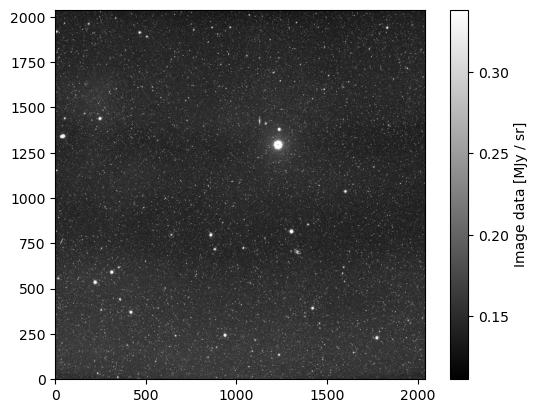

In [4]:
image = hdul["IMAGE"]
image_header = image.header
image_data = image.data

plt.imshow(image_data, origin='lower', cmap='gray', vmin=np.percentile(image_data, 1), vmax=np.percentile(image_data, 99))
unit = image_header["BUNIT"]
plt.colorbar(label=f"Image data [{unit}]")
plt.show()

#### Image header

Note the presence of standard FITS headers for start, end, and mid-point of the exposure:

- `MJD-BEG`, `MJD-END`, `MJD-AVG` for the Modified Julian Date of exposure start, end, and mid-point.
- `DATE-BEG`, `DATE-END`, `DATE-AVG` for ISO-8601 time of exposure start, end, and mid-point.
- `XPOSURE` and `TELAPSE` for scientifically meaningful exposure time and elapsed time.
- Main WCS that describes the astrometric registration of the image, including optical distortion parameters.
- Alternative WCS 'A' that describes zero-based pixel coordinates.
- Alternative WCS 'W' that describes spectral coordinates 'Wavelength' and 'Bandpass'. (This WCS contains a reference to the lookup table in the 'WCS-WAVE' extension.)

Many additional SPHEREx-specific headers are also present. These are subject to change before the first public release of data. Some of the headers shown in this example are specific to the SPHEREx image simulator and will not be present in real data from the Observatory.

In [5]:
image_header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2040                                                  
NAXIS2  =                 2040                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
VERSION = '3.3.0   '           / Sky Simulator software version                 
JD      =    2460790.543511511 / Julian Date                                    
ARRAY   =                    1 / SPHEREx detector array                         
OVERSAMP=                    5 / oversample factor for high res image           
RWJITTER=  0.03449718140922521 / Random walk jitter rms [ arcsec ]              
CAL     =     8.286699900048

#### Spatial WCS

In [6]:
# Load Spatial WCS
wcs = WCS(header=hdul["IMAGE"].header)
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP' 'DEC--TAN-SIP' 
CRVAL : 177.335687877 47.94309366645 
CRPIX : 1020.5 1020.5 
PC1_1 PC1_2  : -0.0013510756805829 -0.00098494515408864 
PC2_1 PC2_2  : 0.0010360507148361 -0.0013925379997908 
CDELT : 1.0 1.0 
NAXIS : 2040  2040

#### Spectral WCS

The use of Linear Variable Filters (LVFs) is a key component of SPHEREx imaging. Each pixel of the detector corresponds to a slightly different wavelength and bandwidth due to the LVF's gradual variation in spectral transmission across its surface. Contours of constant wavelength are curved due to the method of filter fabrication, so the wavelength-vs-pixel function is inherently two-dimensional.

A compact, approximate representation of the wavelength and bandwidth per pixel is included in each image using the `WAVE-TAB` lookup-table mechanism defined in the FITS standard, primarily to support visualization. The precise mapping will be provided as a separate set of calibration data products along with the first public data release.

The code below illustrates how to use Spectral WCS to find an approximate wavelength at each pixel.

In [7]:
# Load Spectral WCS
# Note that we need to provide a reference to HDU List, which contains a lookup table 
spectral_wcs = WCS(header=hdul["IMAGE"].header, fobj=hdul, key="W")

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


---
Note: The previous line triggers an Astropy INFO printout, which implies that the SIP distortion coefficients from the main WCS are preserved in the alternative WCS. (This is because the SIP convention, not formally part of the FITS standard, is ambiguous as to whether it is meant to apply to 'alternative' (lettered) WCSes in addition to the primary WCS. See [astropy/astropy#13105](https://github.com/astropy/astropy/issues/13105).)

The wavelength per pixel is a property of the detector-filter combination and is independent of optical distortion in the telescope, and is modeled accordingly in WCS 'W', so we turn the SIP distortion off for this WCS.

In [8]:
# SIP distortions must be turned off for the spectral WCS.
spectral_wcs.sip = None

#### Coordinate Conversion

The standard Astropy methods for converting pixel coordinates to world coordinates are used to obtain spectral coordinates.

In [9]:
# Take an (ra,dec) coordinate pair and resolve it to pixel coordinates in the image
# Using RA and Dec at the reference point (center of the array) as an example
ra, dec = wcs.wcs.crval  
x, y = wcs.world_to_pixel(SkyCoord(ra=ra, dec=dec, unit="deg"))

# Take the pixel coordinates and resolve them to the wavelength and bandpass for that pixel
wl, bp = spectral_wcs.pixel_to_world(x, y)

wl, bp

(<SpectralCoord 0.90607952 um>, <Quantity 0.02199222 um>)

#### Plotting Approximated Wavelength

Numpy array operations can be used to produce an approximate map of the distribution of the central filter wavelength across the whole detector.

In [10]:
# y corresponds to numpy rows
# x corresponds to numpy columns
(y, x) = np.indices(image_data.shape)
spectral_coords = spectral_wcs.pixel_to_world(x, y)

wavelength, bandpass = spectral_coords
print("Wavelength: \n", wavelength)
print("Bandpass: \n", bandpass)

Wavelength: 
 [[1.12894186 1.12892164 1.12890142 ... 1.12890139 1.12892163 1.12894186]
 [1.12871964 1.12869942 1.1286792  ... 1.12867917 1.1286994  1.12871964]
 [1.12849741 1.1284772  1.12845698 ... 1.12845695 1.12847718 1.12849741]
 ...
 [0.74587883 0.74586195 0.74584507 ... 0.74584505 0.74586194 0.74587883]
 [0.74572201 0.74570513 0.74568825 ... 0.74568823 0.74570512 0.74572201]
 [0.74556519 0.74554832 0.74553144 ... 0.74553142 0.74554831 0.74556519]] um
Bandpass: 
 [[0.0274015  0.02740101 0.02740052 ... 0.02740052 0.02740101 0.0274015 ]
 [0.02739611 0.02739562 0.02739513 ... 0.02739513 0.02739562 0.02739611]
 [0.02739071 0.02739022 0.02738973 ... 0.02738973 0.02739022 0.02739071]
 ...
 [0.01810386 0.01810345 0.01810304 ... 0.01810304 0.01810345 0.01810386]
 [0.01810005 0.01809964 0.01809923 ... 0.01809923 0.01809964 0.01810005]
 [0.01809624 0.01809583 0.01809542 ... 0.01809542 0.01809583 0.01809624]] um


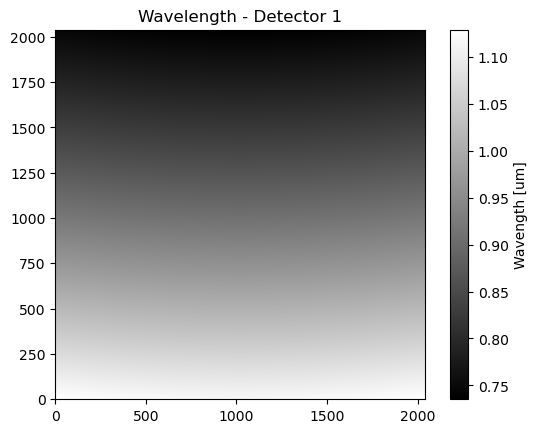

In [11]:
plt.imshow(wavelength.value, origin='lower', cmap='gray')
plt.colorbar(label=f"Wavength [{wavelength.unit}]")

detector = hdul["IMAGE"].header["ARRAY"]  # The header will be "DETECTOR"
plt.title(f"Wavelength - Detector {detector}")
plt.show()

### FLAGS

SPHEREx deploys bit masks to flag pixels in the images. The bit masks have symbolic names that are recorded in the FITS headers with a prefix `MP_` (or `HIERARCH MP_` for longer names), and a value equal to the power of two for the corresponding value. For example, “MP_FOO = 5” would mean that the symbolic name “FOO” has the corresponding value of decimal 32, hexadecimal 0x20, or binary 100000. This is the same convention used by the Rubin Observatory for documenting bit planes for flag-valued pixel data.

In [12]:
flags = hdul["FLAGS"]
flags_header = flags.header
key_values = {(key, flags_header[key]) for key in flags_header if key.startswith("MP_")}
flags_dict = dict(sorted(key_values, key=lambda x: x[1]))
flags_dict

{'MP_TRANSIENT': 0,
 'MP_OVERFLOW': 1,
 'MP_CHKSUM_ERR': 2,
 'MP_PHANTOM': 4,
 'MP_REFERENCE': 5,
 'MP_DICHROIC': 7,
 'MP_HOT': 10,
 'MP_COLD': 11,
 'MP_FULLSAMPLE': 12,
 'MP_NONLINEAR': 15,
 'MP_OUTLIER': 19,
 'MP_CROSSTALK': 20,
 'MP_SOURCE': 21}

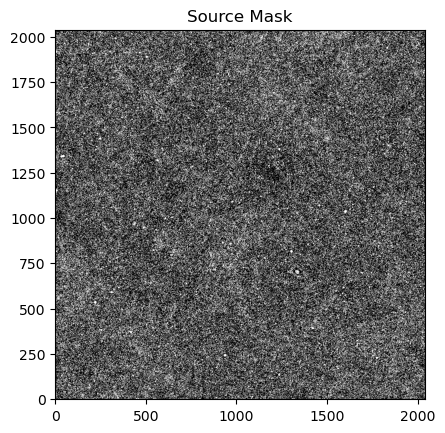

In [13]:
# Show pixels that have SOURCE flag on
source_flag_val = 2 ** flags_dict["MP_SOURCE"]
flag_data = flags.data
plt.imshow(flag_data & source_flag_val > 0, origin='lower', cmap='gray')
plt.title(f"Source Mask")
plt.show()